In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [2]:
bag = rosbag.Bag('/home/hakanergin/code/rosbags/static/rotation/36h11/s_yaw_36h11_2m_1080_20.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60,75]

In [3]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,31.195044
1,1.638606,7.525761
2,2.520315,-0.306474
3,3.401566,1.730796
4,4.111644,3.668143
...,...,...
295,101.914027,-0.292694
296,102.255752,-0.288678
297,102.626892,-0.237157
298,102.948920,-0.352735


<AxesSubplot:xlabel='relative_time'>

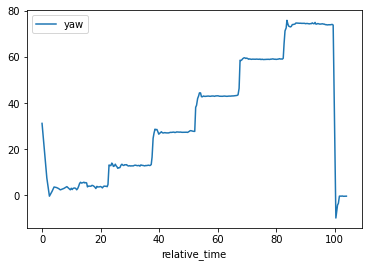

In [5]:
# initial graph
df.plot(x='relative_time', y=target)

In [6]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 5)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [7]:
# the amount of data points we are left with
len(x[peaks])

70

In [8]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

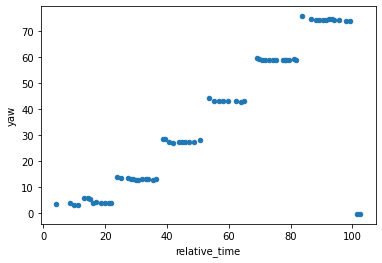

In [9]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [10]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,yaw,true_yaw
4,4.111644,3.668143,0
9,8.483940,3.822332,0
11,9.990057,3.120352,0
15,11.232440,3.211670,0
21,13.158677,5.714487,0
...,...,...,...
279,95.817714,74.292141,75
286,98.049526,73.891642,75
289,99.116843,74.032750,75
294,101.590859,-0.280723,0


In [11]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [12]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [13]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,yaw,true_yaw,error
4,4.111644,3.668143,0,-3.668143
9,8.483940,3.822332,0,-3.822332
55,23.831177,14.005556,15,0.994444
59,25.030119,13.535263,15,1.464737
101,38.588365,28.702141,30,1.297859
103,39.238060,28.575802,30,1.424198
150,53.776127,44.397873,45,0.602127
154,55.131247,43.046059,45,1.953941
198,69.238403,59.592491,60,0.407509
200,69.923179,59.449309,60,0.550691


In [14]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,15.0,-3.646047,1.784374,-5.740343,-4.226377,-3.938149,-3.439907,0.280723
15,12.0,1.766055,0.334352,0.994444,1.619768,1.840886,1.992481,2.188097
30,10.0,2.282782,0.537471,1.297859,2.060593,2.532797,2.592552,2.802576
45,8.0,1.785909,0.479557,0.602127,1.927002,1.954939,1.977675,1.996061
60,13.0,0.892897,0.198245,0.407509,0.906287,0.967060,1.016984,1.075743
75,12.0,0.460964,0.478702,-0.787742,0.351691,0.533437,0.656275,1.108358


In [15]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

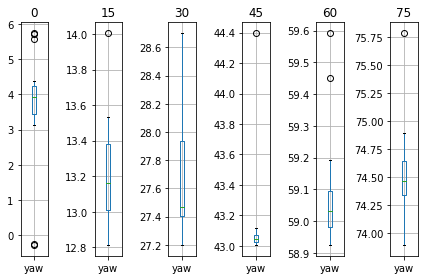

In [16]:
box_plotter(target)

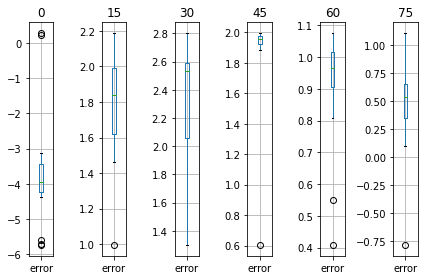

In [17]:
box_plotter('error')

In [18]:
df_filtered_by_targets.to_csv('/home/hakanergin/code/apriltag_test_bench/test_pipeline/scripts/static_tests/rotations/result/csv/2m_36h11_1080.csv')